In [1]:
from skimage.io import imread, imshow
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from sen1floods11_dataset import Sen1Floods11Dataset, Sen1Floods11DataModule

In [20]:
import os
ROOT = os.path.dirname(os.getcwd())
hand_labeled_data = os.path.join(ROOT, 'sen1floods11', 'hand_labeled.csv')
weak_labeled_data = os.path.join(ROOT, 'sen1floods11', 'weak_labeled.csv')
ROOT

'/home/genrev_kiel_hizon/SAR_flood_segmentation'

In [14]:
def sample_img(dataset, idx=None):
    if not idx:
        idx = np.random.randint(len(dataset))
        
    _, ax = plt.subplots(1,3)
    
    ax[0].imshow(dataset['img'][idx][0])
    ax[1].imshow(dataset['img'][idx][1])
    ax[2].imshow(dataset['label'][idx])
    
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        
    plt.show()
    
    return None

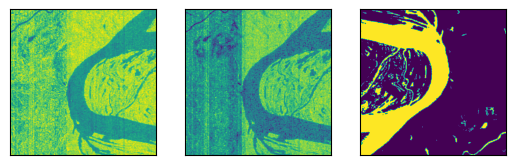

In [21]:
hand_labeled = Sen1Floods11DataModule(hand_labeled_data, 'HandLabeled', 8, debug=False, transforms=True)
hand_labeled.prepare_data()
train = hand_labeled.train_dataloader()
sample_img(next(iter(train)))

In [5]:
# weakly_labeled = Sen1Floods11DataModule(weak_labeled_data, 'WeaklyLabeled', 8, debug=True)
# weakly_labeled.prepare_data()
# train = weakly_labeled.train_dataloader()
# sample_img(next(iter(train)))

<Axes: ylabel='Count'>

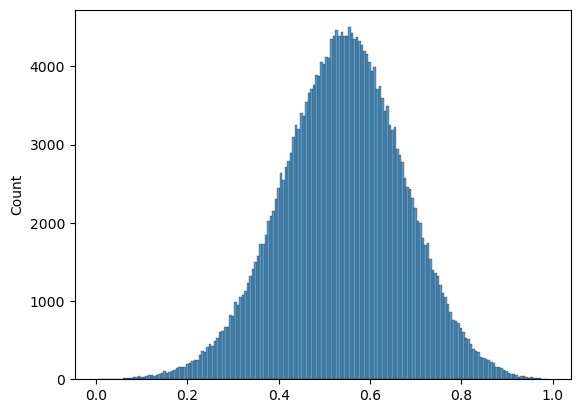

In [18]:
batch = next(iter(train))
test_img = batch['img'][7].numpy()

sns.histplot(test_img[0].flatten())

In [19]:
test_img[test_img<0].shape

(0,)